##### Copyright 2024 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2024-10-03 16:12:33.345340: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 16:12:33.430516: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 16:12:33.916376: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 16:12:34.385454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 16:12:34.760771: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [4]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


I0000 00:00:1723784907.495092  160375 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723784907.498985  160375 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723784907.502627  160375 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723784907.506226  160375 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


I0000 00:00:1723784911.543932  160540 service.cc:146] XLA service 0x7f8910006f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723784911.543965  160540 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1723784911.543969  160540 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1723784911.543973  160540 service.cc:154]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1723784911.543976  160540 service.cc:154]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:03:55 2s/step - loss: 0.1735


  43/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1347    


  90/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1133


 137/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1008

I0000 00:00:1723784912.197500  160540 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



 183/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0925


 229/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0863


 276/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0812


 323/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0771


 369/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0737


 415/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0708


 462/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0682


 509/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0659


 556/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0639


 602/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0621


 649/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0604


 695/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0590


 742/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0576


 789/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0563


 836/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0551


 881/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0540


 922/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0531


 966/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0522


1010/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0513


1055/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0504


1101/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0496


1147/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0489


1193/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0481


1239/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0474


1284/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0468


1328/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0462


1372/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0456


1417/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0450


1462/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0444


1507/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0439


1553/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0434


1598/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0429


1643/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0424


1688/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0420


1732/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0416


1777/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0411


1822/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0407


1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0403


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0402 - val_loss: 0.0134


Epoch 2/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0130


  46/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0131   


  95/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132


 143/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132


 192/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132


 240/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132


 289/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132


 338/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131


 387/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131


 434/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131


 482/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130


 531/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130


 580/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130


 629/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130


 677/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129


 726/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129


 774/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129


 822/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129


 871/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128


 920/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128


 967/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128


1013/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128


1060/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127


1109/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127


1158/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127


1207/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127


1256/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127


1306/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126


1354/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126


1402/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126


1452/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126


1501/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125


1551/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125


1600/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125


1649/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125


1697/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125


1746/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124


1793/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124


1841/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0124 - val_loss: 0.0106


Epoch 3/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:26 46ms/step - loss: 0.0134


  47/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0111   


  94/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0109


 141/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0108


 187/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0108


 235/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0108


 282/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0107


 328/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0107


 375/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0107


 422/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0107


 470/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106


 519/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106


 566/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106


 613/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106


 660/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106


 707/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106


 755/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106


 803/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106


 851/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105


 899/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105


 947/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105


 995/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105


1043/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105


1090/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105


1138/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105


1186/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105


1233/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105


1281/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105


1330/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105


1378/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1427/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1476/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1524/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1570/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1616/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1663/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1710/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1757/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1804/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0104 - val_loss: 0.0098


Epoch 4/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0102


  46/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0099   


  93/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0099


 141/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0099


 189/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0099


 236/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098


 283/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098


 331/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098


 379/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098


 426/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098


 473/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098


 521/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098


 570/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097


 618/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097


 667/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097


 714/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097


 762/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097


 810/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097


 858/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097


 906/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0097


 953/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1001/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1049/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1097/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1144/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1192/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1240/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1287/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1336/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1384/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1432/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1480/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1528/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1575/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1622/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1670/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1718/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1766/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1814/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0097 - val_loss: 0.0095


Epoch 5/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:26 46ms/step - loss: 0.0094


  47/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090   


  94/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0091


 141/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 188/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 235/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 282/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 330/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 377/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 423/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 470/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 516/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 564/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 612/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 659/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 706/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 752/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 799/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 845/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 892/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 939/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0093


 987/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1035/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1083/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1132/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1180/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1229/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1277/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1324/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1371/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1419/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1467/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1515/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1563/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1610/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1657/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1704/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1752/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1800/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0093 - val_loss: 0.0092


Epoch 6/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0075


  46/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0090   


  91/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0092


 135/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 181/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 228/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 275/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 322/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 370/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 416/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 461/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 506/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 552/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 598/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 645/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 693/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 739/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 787/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 834/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 880/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 925/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092


 971/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1015/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1060/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1105/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1149/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1194/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1241/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1286/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1332/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1378/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1423/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1469/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1515/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1561/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1606/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1652/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1698/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1745/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1793/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1840/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0092 - val_loss: 0.0091


Epoch 7/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:23 45ms/step - loss: 0.0086


  47/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088   


  94/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 141/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 188/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 237/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 286/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 334/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 380/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 427/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 475/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 523/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 571/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 618/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 665/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 712/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 758/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 805/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 852/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 899/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 946/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


 993/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1040/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1087/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1134/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1181/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1228/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1275/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1322/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1369/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1417/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1464/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1512/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1559/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1605/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1651/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1698/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1745/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1792/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1838/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0090 - val_loss: 0.0090


Epoch 8/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:27 47ms/step - loss: 0.0090


  48/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090   


  96/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 144/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 191/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 240/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 287/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 336/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 385/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 434/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 482/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 530/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 578/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 626/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 673/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 720/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 768/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 817/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 866/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 914/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090


 962/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1010/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1058/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1105/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1154/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1202/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1248/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1296/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1344/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090


1392/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1440/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1489/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1537/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1586/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1634/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1681/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1729/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1777/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1826/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089 - val_loss: 0.0089


Epoch 9/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:24 45ms/step - loss: 0.0100


  47/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0090   


  94/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 141/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 188/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 235/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 282/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 329/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 375/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 421/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 468/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 516/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 564/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 613/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 661/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 709/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 757/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 805/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 853/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 901/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0089


 949/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


 997/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1045/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1092/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1138/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1185/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1232/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1279/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1327/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1375/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1424/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1473/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1522/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1570/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1618/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1666/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1714/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1763/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1812/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089 - val_loss: 0.0089


Epoch 10/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0081


  47/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0085   


  96/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086


 145/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086


 194/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087


 243/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087


 291/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087


 338/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087


 385/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0087


 432/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 479/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 525/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 572/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 619/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 668/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 717/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 767/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 816/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 865/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 914/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088


 960/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1006/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1052/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1098/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1145/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1193/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1241/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1289/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1336/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1382/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1429/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1475/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1522/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1568/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1614/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1660/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1706/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1753/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1799/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1845/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088 - val_loss: 0.0090


Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

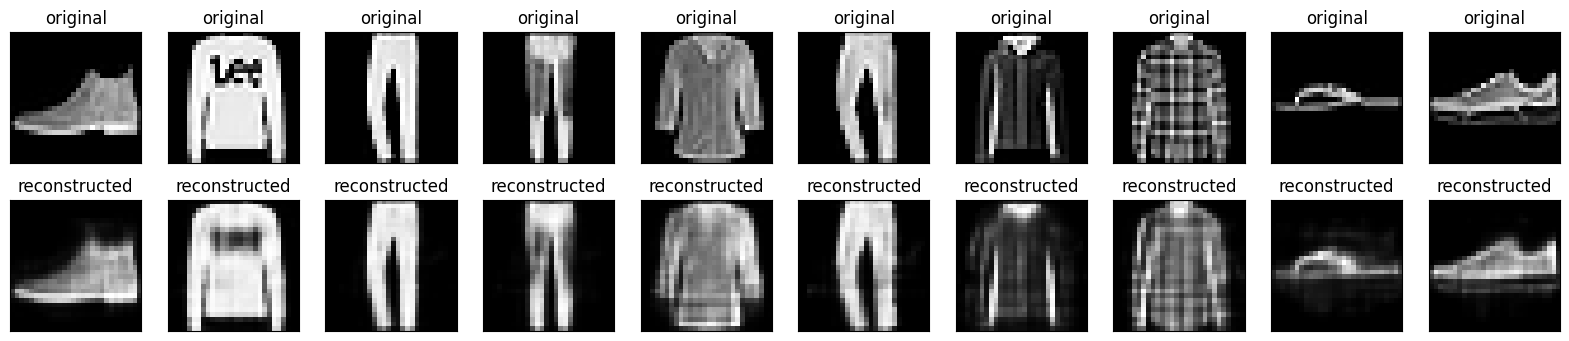

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


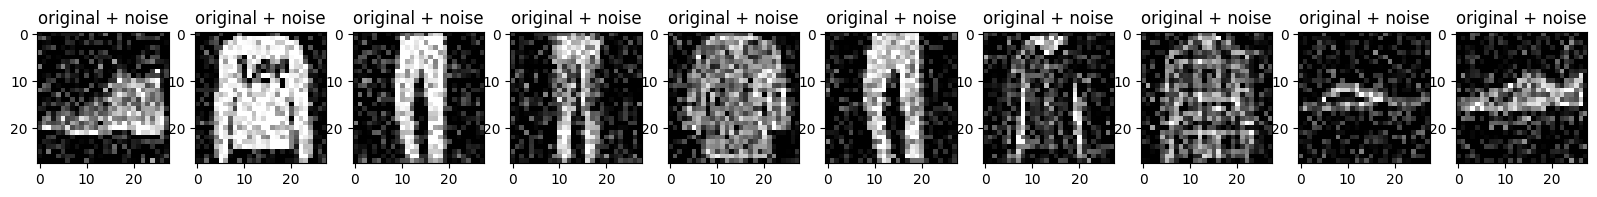

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:28:19 3s/step - loss: 0.1770


  30/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1660    


  61/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1559


  94/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1416


 126/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1284


 158/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1175


 189/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1088


 221/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1013


 253/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0950


 285/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0896


 317/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0850


 350/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0808


 382/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0773


 415/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0741


 446/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0713


 479/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0687


 512/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0664


 545/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0642


 578/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0622


 611/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0604


 644/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0588


 678/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0572


 713/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0557


 747/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0543


 780/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0530


 814/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0519


 848/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0507


 881/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0497


 914/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0487


 946/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0479


 979/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0470


1011/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0462


1044/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0454


1077/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0447


1110/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0440


1143/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0433


1175/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0427


1208/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0420


1241/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0414


1274/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0409


1308/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0403


1341/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0398


1375/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0393


1408/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0388


1441/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383


1474/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0379


1507/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0374


1539/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0370


1571/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366


1603/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0362


1634/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0359


1667/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0355


1699/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352


1731/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0348


1763/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0345


1796/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0342


1828/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339


1860/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0336


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0334 - val_loss: 0.0095


Epoch 2/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:29 48ms/step - loss: 0.0105


  29/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0095   


  57/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0095


  86/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0095


 116/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094


 147/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094


 176/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094


 205/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094


 234/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094


 263/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094


 291/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094


 320/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0094


 349/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 378/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 407/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 436/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 465/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 494/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 523/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 551/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 580/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 609/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 639/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 667/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 696/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 724/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093


 753/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093


 782/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093


 810/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


 839/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


 868/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


 896/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


 924/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


 952/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


 980/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1008/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1036/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1064/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1092/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1120/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1148/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1176/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1204/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1232/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1260/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1288/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092


1316/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1343/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1371/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1399/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1427/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1455/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1483/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1511/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1539/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1566/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1594/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1622/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1650/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1679/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1708/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1737/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1766/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1794/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1822/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0091 - val_loss: 0.0083


Epoch 3/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:28 47ms/step - loss: 0.0085


  28/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084   


  55/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0084


  82/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0083


 109/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0083


 136/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0083


 164/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0083


 192/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0083


 220/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0083


 248/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0083


 276/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 303/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 331/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 359/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 387/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 414/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 441/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 468/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 495/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 523/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 551/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 579/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 606/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 634/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 661/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 688/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083


 716/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082


 744/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082


 772/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082


 800/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


 827/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


 855/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


 883/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


 911/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


 939/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


 967/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


 995/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1022/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1050/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1078/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1106/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1134/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1161/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1189/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1217/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1245/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1273/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1301/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1328/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082


1356/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1384/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1411/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1438/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1465/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1492/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1518/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1545/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1571/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1597/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1624/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1651/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1678/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1705/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1732/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1759/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1786/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1813/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1840/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1867/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0082 - val_loss: 0.0078


Epoch 4/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:27 47ms/step - loss: 0.0078


  27/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078   


  53/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079


  78/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079


 104/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079


 130/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079


 156/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0079


 182/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078


 207/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078


 233/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078


 259/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078


 285/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078


 311/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078


 337/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078


 363/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 389/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 415/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 442/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 468/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 494/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 520/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 546/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 572/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 598/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 624/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 651/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 678/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 706/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 733/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 760/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 787/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 814/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 841/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0078


 868/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


 895/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


 922/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


 950/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


 978/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1005/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1033/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1060/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1088/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1116/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1144/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1172/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1199/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1227/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1255/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1283/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1311/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1339/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078


1367/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1395/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1423/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1451/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1479/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1506/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1534/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1561/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1588/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1616/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1644/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1672/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1700/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1728/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078


1756/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077


1784/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077


1811/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077


1838/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077


1866/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0077 - val_loss: 0.0076


Epoch 5/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:28 47ms/step - loss: 0.0083


  29/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0076   


  57/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0075


  86/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0075


 114/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0075


 142/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0075


 171/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0075


 200/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 229/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 258/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 287/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 316/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 345/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 374/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 403/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 432/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 461/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 490/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 519/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 548/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 577/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 606/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 635/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 664/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 694/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 723/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075


 752/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


 781/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


 810/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


 839/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


 868/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


 897/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


 926/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


 955/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


 984/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1013/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1042/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1071/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1100/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1129/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1158/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1187/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1216/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1245/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1274/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1303/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075


1332/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1361/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1390/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1419/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1448/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1477/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1506/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1535/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1564/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1594/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1624/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1653/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1682/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1710/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1739/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1768/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1797/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1826/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1855/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0075 - val_loss: 0.0074


Epoch 6/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:26 46ms/step - loss: 0.0076


  29/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0073   


  58/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0073


  88/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0073


 118/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0073


 147/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 177/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 206/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 236/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 266/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 296/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 327/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 358/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 389/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 420/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 450/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 481/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 513/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 544/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 575/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 606/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 638/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 670/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073


 702/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


 733/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


 764/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


 795/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


 827/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


 859/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


 891/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


 922/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


 954/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


 986/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


1018/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


1050/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


1082/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


1113/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


1145/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


1176/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


1207/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


1239/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073


1271/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1303/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1335/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1366/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1397/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1428/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1459/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1491/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1522/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1553/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1585/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1616/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1648/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1680/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1711/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1742/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1773/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1805/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1837/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1869/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0073 - val_loss: 0.0073


Epoch 7/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:24 45ms/step - loss: 0.0066


  30/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072   


  60/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072


  88/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072


 117/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072


 146/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072


 175/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 203/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 231/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 260/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 289/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 318/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 347/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 376/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 405/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 434/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 462/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 491/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 520/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 549/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 578/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 607/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 636/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 665/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 694/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 722/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 750/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


 779/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


 808/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


 837/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


 866/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


 895/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


 924/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


 953/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


 982/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1011/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1041/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1070/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1100/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1129/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1158/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1187/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1216/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1245/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1274/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1303/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072


1333/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1363/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1392/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1420/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1448/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1477/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1507/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1537/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1567/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1596/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1625/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1654/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1683/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1712/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1741/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1771/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1801/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1831/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1861/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0072 - val_loss: 0.0072


Epoch 8/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:27 47ms/step - loss: 0.0067


  29/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072   


  58/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0073


  87/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0073


 116/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0073


 146/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072


 176/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 205/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 234/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 263/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 293/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 322/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 350/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 378/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 407/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 436/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 465/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 494/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 524/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 553/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072


 583/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 612/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 641/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 670/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 699/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 728/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 757/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 786/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 815/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 843/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 871/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 900/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 929/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 957/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 986/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1016/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1045/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1074/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1103/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1132/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1161/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1190/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1219/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1249/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1279/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1308/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1337/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1367/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1396/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1425/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1454/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1483/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1512/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1541/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1570/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1599/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1628/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1657/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1687/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1716/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1745/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1774/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1804/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1833/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1862/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0071 - val_loss: 0.0071


Epoch 9/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0072


  30/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0072   


  59/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0071


  88/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0071


 117/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0071


 147/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0071


 177/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 207/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 237/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 267/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 297/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 327/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 357/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 387/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 417/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 447/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 477/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 507/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 536/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 566/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 595/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 624/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 654/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 683/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 712/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071


 742/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 772/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 802/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 831/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 861/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 891/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 921/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 950/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


 980/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1010/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1040/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1070/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1100/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1130/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1160/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1191/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1221/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1251/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1280/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071


1310/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1341/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1371/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1402/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1433/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1464/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1495/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1525/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1556/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1587/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1617/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1647/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1676/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1705/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1734/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1763/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1792/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1821/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0071 - val_loss: 0.0070


Epoch 10/10



   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - loss: 0.0069


  30/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069   


  59/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069


  88/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0068


 117/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069


 146/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069


 175/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 204/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 234/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 264/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 294/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 323/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 352/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 382/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 411/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 440/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 469/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 499/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 528/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 557/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 586/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 615/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 644/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 675/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 705/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069


 734/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069


 765/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069


 795/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069


 824/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069


 853/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069


 883/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069


 912/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


 941/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


 970/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


 999/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1029/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1058/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1087/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1116/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1145/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1174/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1204/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1235/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1265/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1295/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070


1326/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1356/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1387/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1418/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1449/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1480/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1511/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1541/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1572/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1603/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1634/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1665/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1696/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1727/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1756/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1785/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1814/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0070 - val_loss: 0.0070


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [16]:
autoencoder.encoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

The decoder upsamples the images back from 7x7 to 28x28.

In [17]:
autoencoder.decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (32, 14, 14, 8)        │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (32, 28, 28, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 28, 28, 1)        │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [18]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

W0000 00:00:1723784980.750910  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.770565  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.772594  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.774806  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.777004  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.780048  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.782568  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.785629  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.788932  160375 gp

W0000 00:00:1723784980.961848  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.966838  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.973690  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.980217  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784980.999480  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.013945  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.038542  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.056058  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.077900  160375 gp

W0000 00:00:1723784981.186111  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.207864  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.329616  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.337779  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.352611  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.369650  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


W0000 00:00:1723784981.399198  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.413427  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.443673  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.502975  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.545023  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


W0000 00:00:1723784981.626188  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.642306  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.657118  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.675985  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.707544  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.718098  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.751437  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723784981.774578  160375 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


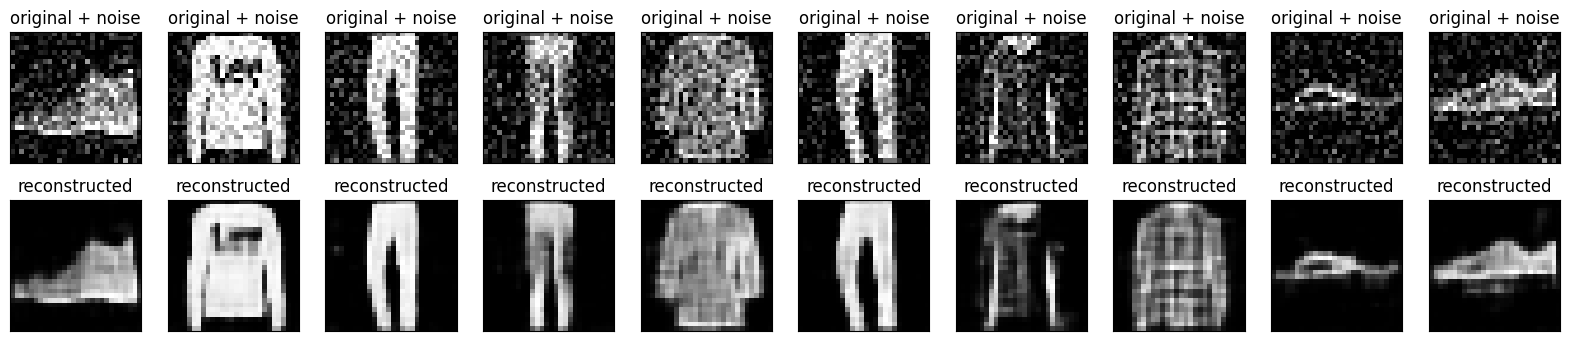

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

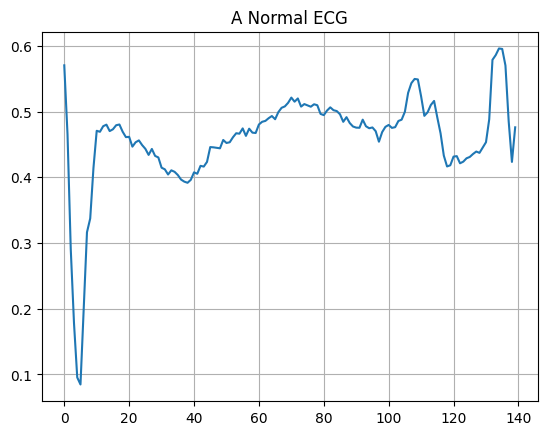

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

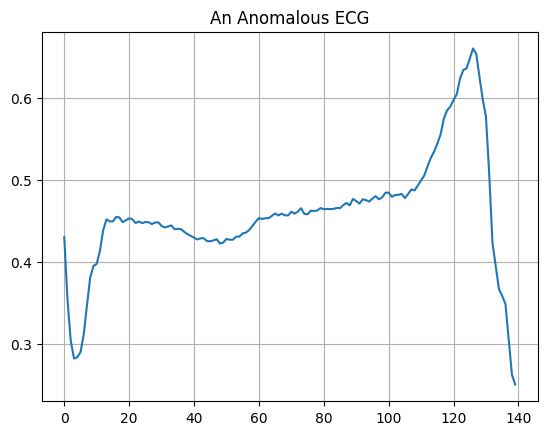

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 0.0588


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.0581


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step - loss: 0.0581 - val_loss: 0.0531


Epoch 2/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0560


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0553 - val_loss: 0.0518


Epoch 3/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0528


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0519 - val_loss: 0.0494


Epoch 4/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0490


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0480 - val_loss: 0.0475


Epoch 5/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0449


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0441 - val_loss: 0.0451


Epoch 6/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0413


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0405 - val_loss: 0.0435


Epoch 7/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0375


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0374 - val_loss: 0.0415


Epoch 8/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0353


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0347 - val_loss: 0.0403


Epoch 9/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0323


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0323 - val_loss: 0.0392


Epoch 10/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0308


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0303 - val_loss: 0.0380


Epoch 11/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0289


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0286 - val_loss: 0.0373


Epoch 12/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0273


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0272 - val_loss: 0.0367


Epoch 13/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0258


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0258 - val_loss: 0.0359


Epoch 14/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0257


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0253 - val_loss: 0.0354


Epoch 15/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0247


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0244 - val_loss: 0.0349


Epoch 16/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0236


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0236 - val_loss: 0.0342


Epoch 17/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0228


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0228 - val_loss: 0.0336


Epoch 18/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0215


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0220 - val_loss: 0.0330


Epoch 19/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0211


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0215 - val_loss: 0.0326


Epoch 20/20



1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0213


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0213 - val_loss: 0.0323


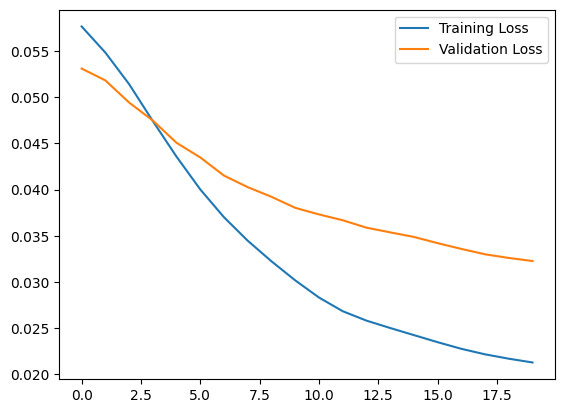

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

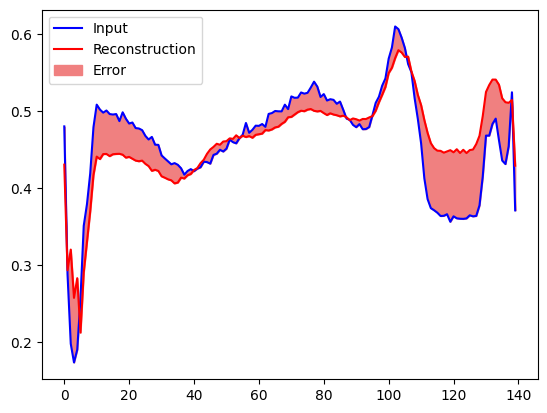

In [30]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

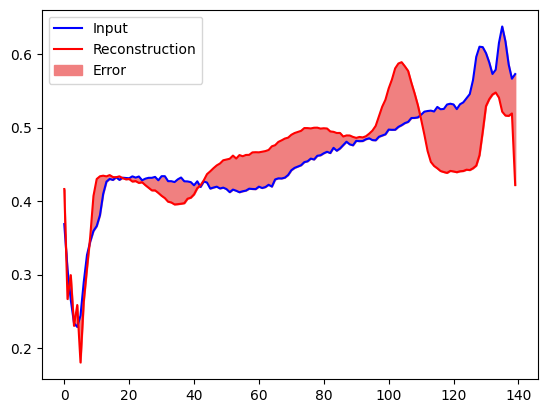

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set


 1/74 ━━━━━━━━━━━━━━━━━━━━ 31s 425ms/step


48/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


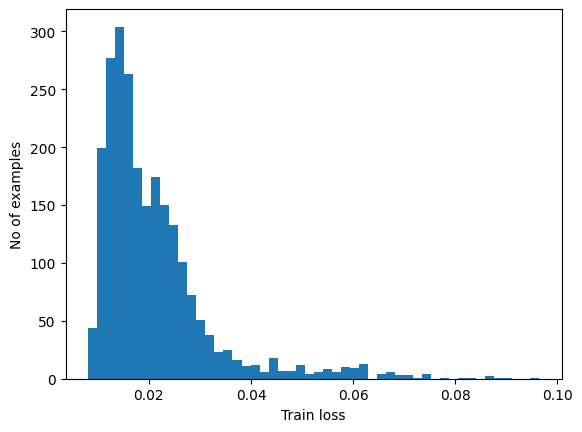

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032343477


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial.

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier.


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


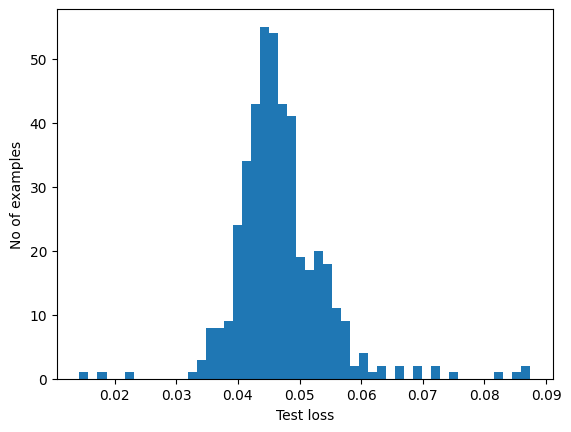

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571


## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
